/mnt/c/Users/frami/OneDrive - Universidad Adolfo Ibanez/ComputerCodes/Python/plasmon-hc-clusters/plytrons/bcm_sphere.py:252: RuntimeWarning: invalid value encountered in divide
  vector = np.array(vector) / np.array(vector)


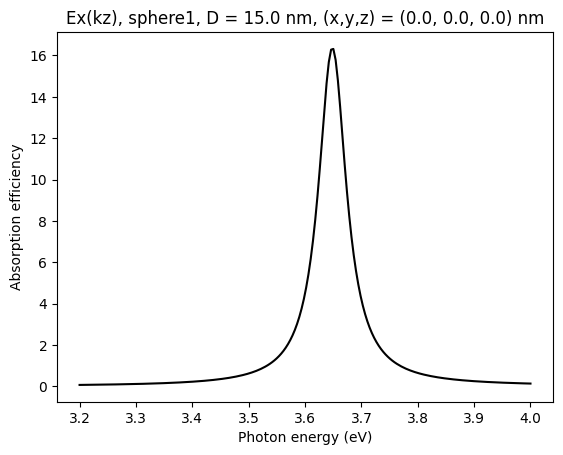

In [1]:
import numpy as np
import plytrons.bcm_sphere as bcm
from plytrons.bcm_sphere import EField, BCMObject
from plytrons.hot_carriers import lm_to_idx
from scipy.constants import hbar, eV, speed_of_light
from scipy.constants import physical_constants
import matplotlib.pyplot as plt

c0 = speed_of_light
Z0, *_ = physical_constants[ "characteristic impedance of vacuum"]
Z0 = Z0 * eV          # Free space impedance (e/V-s)

# Define geometrical parameters
D = 15                      # Diameter of spheres (nm)
lmax = 10                  # Maximum spherical harmonic index

# Define Drude model (silver)
wp = 9.07 * eV / hbar  # rad/s
gw = 0.060 * eV / hbar  # rad/s
eps_b = 4.18

# Define simulation setup
eps_h = 1                                   # Dielectric constant of host
w = np.linspace(3.2, 4.0, 200) * eV / hbar  # frequencies

def eps_drude(x):
    return eps_b - wp**2 / ((2*np.pi*c0 / x*1E6) * ((2*np.pi*c0 / x * 1E6) + 1j * gw))

efield = EField(
    E0=1,                                 # E-field intensity (V/nm)
    k_hat=bcm.v_normalize([0, 0, 1]),     # Planewave direction
    e_hat=bcm.v_normalize([1, 0, 0])      # E-field vector
)

BCM_objects = [
    BCMObject(
        label='Sphere1',
        diameter=D,
        lmax=lmax,
        eps=eps_drude,
        position=np.array([0, 0, 0])
    ),
]

# Number of spheres
Np = len(BCM_objects)

# Compute interaction matrices and vector
Gi = [None] * Np
G0 = [[None for _ in range(Np)] for _ in range(Np)]
Sv = [None] * Np

for in_idx in range(Np):
    # Compute internal matrix
    Gi[in_idx] = bcm.Ginternal(BCM_objects[in_idx])
    
    # Compute external interaction matrix
    for jn_idx in range(Np):
        G0[in_idx][jn_idx] = bcm.Gexternal(BCM_objects[in_idx], BCM_objects[jn_idx])
    
    # Compute external field coefficients
    Sv[in_idx] = bcm.Efield_coupling(BCM_objects[in_idx], efield)

#-----------------------------------------------------------------------------------------------------
# Solve system
#-----------------------------------------------------------------------------------------------------
Sw = [None] * Np

dx_max = lmax * (lmax + 1) + (lmax + 1) - 1

obj_coef = []
for coef in range(Np):
    obj_coef.append(np.zeros((dx_max, len(w)), dtype=complex))

for il in range(len(w)):
    c, Si = bcm.solve_BCM(w[il], eps_h, BCM_objects, efield, Gi, G0, Sv)
    for in_idx in range(Np):
        obj_coef[in_idx][:, il] = c[in_idx]
        if il == 0:
            Sw[in_idx] = np.zeros((len(Si[in_idx]), len(w)), dtype=complex)
        Sw[in_idx][:, il] = Si[in_idx]

lam_um = 2*np.pi*3E14/w
for idx_obj in range(Np):
    BCM_objects[in_idx].set_coefficients(lam_um, obj_coef[idx_obj])

# Compute scattering and absorption
Psca, Pabs = bcm.EM_power(w, eps_h, Gi, G0, BCM_objects)

for in_idx, obj in enumerate(BCM_objects):
    # Plot and save figure of spectrum
    plt.figure()
    Ri = obj.diameter / 2
    plt.plot(w * hbar / eV, Pabs[in_idx] / (efield.E0**2 / (2 * Z0)) / (np.pi * Ri**2), 'k')
    
    plt.title(f'E{bcm.get_axis(efield.e_hat)}(k{bcm.get_axis(efield.k_hat)}), sphere{in_idx+1}, ' +
                f'D = {obj.diameter:.1f} nm, (x,y,z) = ({obj.position[0]:.1f}, {obj.position[1]:.1f}, {obj.position[2]:.1f}) nm')
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Absorption efficiency')

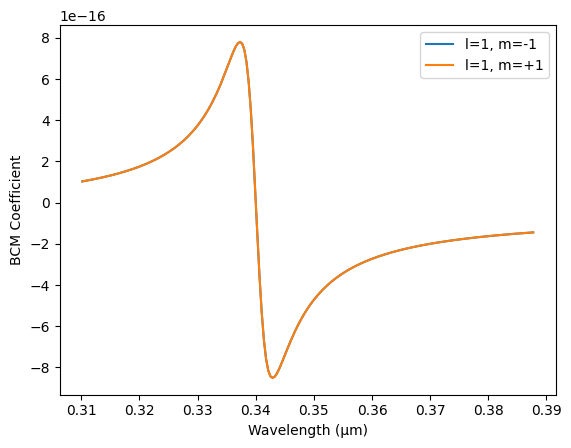

In [2]:
plt.plot(BCM_objects[0].lam_um, BCM_objects[0].BCM_coef[lm_to_idx(l=1, m=0)].real, label='l=1, m=-1')
plt.plot(BCM_objects[0].lam_um, BCM_objects[0].BCM_coef[lm_to_idx(l=1, m=0)].real, label='l=1, m=+1')
plt.legend()
plt.xlabel('Wavelength (μm)')
plt.ylabel('BCM Coefficient')
plt.show()

## Free electron states

We get electronic states from spherical quantum well

In [3]:
import plytrons.quantum_well as qw

a =  D/2
E_matrix = qw.get_bound_states(a)
A_matrix = qw.get_normalization(a, E_matrix)
e_states = qw.e_state_assembly(E_matrix, A_matrix)

## Predicting hot carrier distribution

In [4]:
lam_target = lam_um[np.argmax(Pabs)] # Wavelength at maximum absorption
hv = 2*np.pi*3E14/lam_target*hbar/eV # photon energy (eV)
tau_e = 1.0                          # hot carrier lifetime (ps)
EF    = 5.5        # Fermi level (eV)

print(f'Photon energy: {hv:.2f} eV, Fermi level: {EF:.2f} eV, Hot carrier lifetime: {tau_e:.2f} ps')
X_lm = BCM_objects[0].coef_at(lam_target)

Photon energy: 3.65 eV, Fermi level: 5.50 eV, Hot carrier lifetime: 1.00 ps


In [5]:
from plytrons.hot_carriers import hot_e_dist
Te, Th = hot_e_dist(a, hv, EF, tau_e, e_states, X_lm)

/mnt/c/Users/frami/OneDrive - Universidad Adolfo Ibanez/ComputerCodes/Python/plasmon-hc-clusters/plytrons/hot_carriers.py:229: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  Mfi_2_block = _M_transition_squared(lf, li, a_nm, X_lm, state_lf, state_li)
/mnt/c/Users/frami/OneDrive - Universidad Adolfo Ibanez/ComputerCodes/Python/plasmon-hc-clusters/plytrons/hot_carriers.py:222: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  state_lf = e_state[lf]
/mnt/c/Users/frami/OneDrive - Universidad Adolfo Ibanez/ComputerCodes/Python/plasmon-hc-clusters/plytrons/hot_carriers.py:229: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  Mfi_2_block = _M_transition_squared(lf, li, a_nm, X_lm, state_lf, state_li)


In [ ]:
from plytrons.math_utils import nb_meshgrid
def convert_raw_hot_e(Te, Th, E):
    idx = np.argsort(E)
    E = E[idx]
    Te = Te[idx]
    Th = Th[idx]
    
    E_plot = np.linspace(min(E), max(E), 1000)
    dE = np.diff(E_plot[:2])
    Phi = lambda x: 1/np.pi*(dE/2)/(x**2 + (dE/2)**2)
    # Phi = lambda x: 1/dE*(np.abs(x) < dE/2)

    EE, EEp = nb_meshgrid(E, E_plot)
    TTe = nb_meshgrid(Te, E_plot)[0]
    TTh = nb_meshgrid(Th, E_plot)[0]

    Te_plot = np.sum(TTe*Phi(EEp - EE), axis = 1)
    Th_plot = np.sum(TTh*Phi(EEp - EE), axis = 1)

    return E_plot, Te_plot, Th_plot

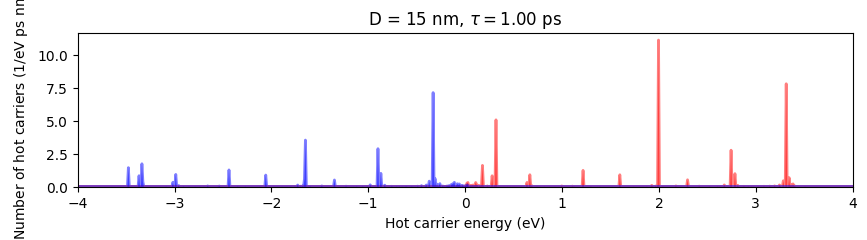

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,2))

E_bound = []
for l in range(len(e_states)):
    E_bound.append(e_states[l].Eb)
E_all = np.concatenate(E_bound).real

x, Te_x, Th_x = convert_raw_hot_e(Te, Th, E_all)
x_lower = np.zeros_like((x - EF))
ax.fill_between( (x - EF), Te_x/hv, x_lower, color = 'r', lw = 2, fc = 'r', alpha = 0.5)
ax.fill_between( (x - EF), Th_x/hv, x_lower, color = 'b', lw = 2, fc = 'b', alpha = 0.5)
ax.set_ylim(bottom=0)
ax.set_xlim(-4,4)
ax.set_xlabel('Hot carrier energy (eV)')
ax.set_ylabel(r'Number of hot carriers ($1/\mathrm{eV~ps~nm}^3$)')
ax.set_title(r'D = %i nm, $\tau = $%.2f ps' % (D, tau_e))
plt.show()